In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import tensorflow as tf

In [2]:
def load_data():
    # 读取数据
    x = np.load('train_data/train_data_emd.npy')
    y = np.load('train_data/label_emd.npy')
    num = len(Counter(y))
    print("类别数量为：", num)
    return x, y, num

In [3]:
def create_train_data(x, y, ratio=0.8):
    """
    x:数据
    y:类别
    ratio:生成训练集比率
    """
    # 打乱顺序
    # 读取data矩阵的第一维数（图片的个数）
    num_example = x.shape[0]
    # 产生一个num_example范围，步长为1的序列
    arr = np.arange(num_example)
    # 调用函数，打乱顺序
    np.random.seed(99)
    np.random.shuffle(arr)
    # 按照打乱的顺序，重新排序
    arr_data = x[arr]
    arr_label = y[arr]
    # 默认将数据集分为训练集80%、测试集20%
    s = int(num_example * ratio)
    x_train = arr_data[:s]
    y_train = arr_label[:s]
    x_val = arr_data[s:]
    y_val = arr_label[s:]
    print("训练集shape", x_train.shape)
    print("训练集类别：", Counter(y_train))
    print("测试集shape", x_val.shape)
    print("测试集类别：", Counter(y_val))
    return x_train, y_train, x_val, y_val

In [4]:
# 读取数据
data, label, label_count = load_data()
# 生成训练集测试集,70%用作训练，30%用作测试
train_data, train_label, val_data, val_label = create_train_data(data, label, 0.7)
print("*"*10)
print("训练集数量：",len(train_label))
print("测试集数量：",len(val_label))

类别数量为： 5
训练集shape (1680, 36, 3)
训练集类别： Counter({1: 345, 4: 339, 2: 336, 3: 336, 0: 324})
测试集shape (720, 36, 3)
测试集类别： Counter({0: 156, 2: 144, 3: 144, 4: 141, 1: 135})
**********
训练集数量： 1680
测试集数量： 720


## 机器学习

In [5]:
# 使用机器学习算法需要对多维数据进行降维
m_train = train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2])
m_val = val_data.reshape(val_data.shape[0],val_data.shape[1]*val_data.shape[2])

# 设置训练迭代次数
epoch = 10

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import model_selection
from sklearn.preprocessing import  OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import graphviz

In [7]:
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(dpi = 150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')

### 决策树

In [8]:
# 决策树
# tree = DecisionTreeClassifier(class_weight = 'balanced', max_depth = None, random_state = None)
tree = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 7, min_samples_leaf = 3, min_samples_split = 2, random_state = None)
# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
for i in range(1,epoch +1):

    # 模型训练
    tree.fit(m_train,train_label)

    # 测试集
    y_pred = np.asarray(tree.predict(m_val),dtype = 'float64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(tree.predict(m_train),dtype = 'float64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)

开始训练
完成第 1 轮训练，测试集准确率： 0.932
完成第 2 轮训练，测试集准确率： 0.931
完成第 3 轮训练，测试集准确率： 0.932
完成第 4 轮训练，测试集准确率： 0.929
完成第 5 轮训练，测试集准确率： 0.932
完成第 6 轮训练，测试集准确率： 0.931
完成第 7 轮训练，测试集准确率： 0.932
完成第 8 轮训练，测试集准确率： 0.932
完成第 9 轮训练，测试集准确率： 0.932
完成第 10 轮训练，测试集准确率： 0.931
平均准确率： 0.9314


In [9]:
y_pred = np.asarray(tree.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.931
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       156
           1       0.88      0.90      0.89       135
           2       0.99      0.95      0.97       144
           3       0.96      0.99      0.97       144
           4       0.87      0.89      0.88       141

    accuracy                           0.93       720
   macro avg       0.93      0.93      0.93       720
weighted avg       0.93      0.93      0.93       720



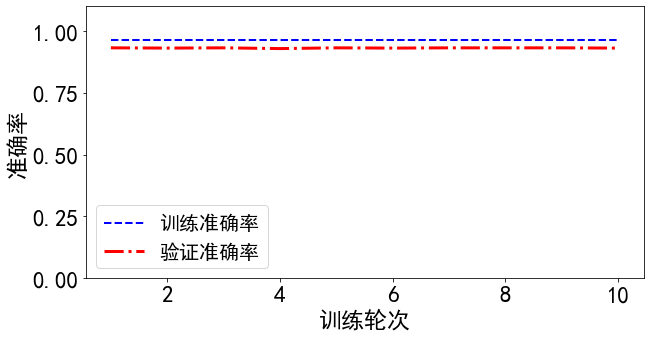

In [10]:
# 设置Y轴范围
plt.figure(figsize=(10,5))
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('训练轮次', fontsize=23)
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['训练准确率','验证准确率'],fontsize=20)
plt.show()

Confusion matrix, without normalization
[[145   0   0   6   5]
 [  4 121   0   0  10]
 [  0   4 137   0   3]
 [  2   0   0 142   0]
 [  2  13   1   0 125]]


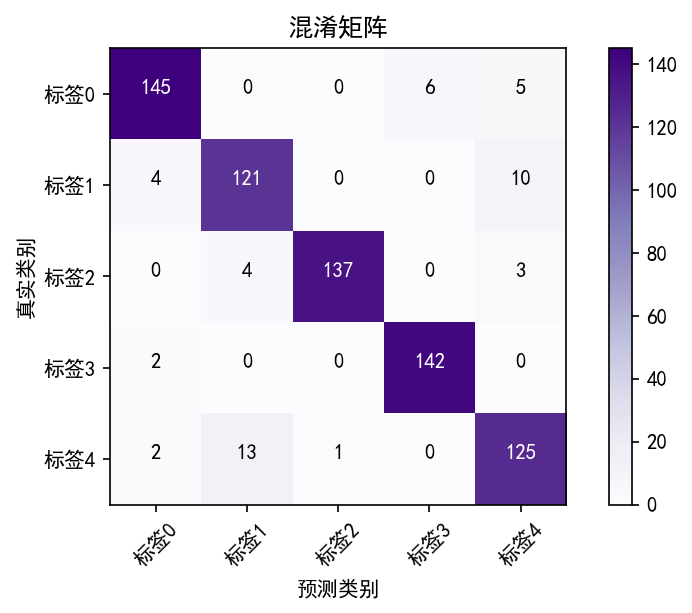

In [11]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")

In [12]:
# 决策树剪枝
import time
times = []
test = []
for i in range(2, 101):
    sum = 0
    start_time = time.time()
    print("i = ", i)
    for j in range(1,epoch +1):
        tree = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 7, min_samples_leaf = 3, min_samples_split = i, random_state = None)
        tree.fit(m_train,train_label)
        y_pred = np.asarray(tree.predict(m_val),dtype = 'int64')
        sum += round(accuracy_score(val_label, y_pred),3) 
    end_time = time.time()
    times.append((end_time - start_time) / epoch)
    score = sum / epoch
    test.append(score)

i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
i =  20
i =  21
i =  22
i =  23
i =  24
i =  25
i =  26
i =  27
i =  28
i =  29
i =  30
i =  31
i =  32
i =  33
i =  34
i =  35
i =  36
i =  37
i =  38
i =  39
i =  40
i =  41
i =  42
i =  43
i =  44
i =  45
i =  46
i =  47
i =  48
i =  49
i =  50
i =  51
i =  52
i =  53
i =  54
i =  55
i =  56
i =  57
i =  58
i =  59
i =  60
i =  61
i =  62
i =  63
i =  64
i =  65
i =  66
i =  67
i =  68
i =  69
i =  70
i =  71
i =  72
i =  73
i =  74
i =  75
i =  76
i =  77
i =  78
i =  79
i =  80
i =  81
i =  82
i =  83
i =  84
i =  85
i =  86
i =  87
i =  88
i =  89
i =  90
i =  91
i =  92
i =  93
i =  94
i =  95
i =  96
i =  97
i =  98
i =  99
i =  100


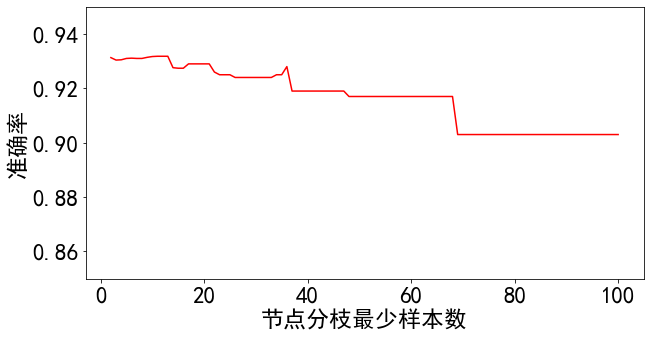

In [13]:
plt.figure(figsize=(10,5))
plt.ylim(0.85,0.95)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('节点分枝最少样本数', fontsize=23)
plt.plot(range(2, 101),test,color="red")
plt.show()

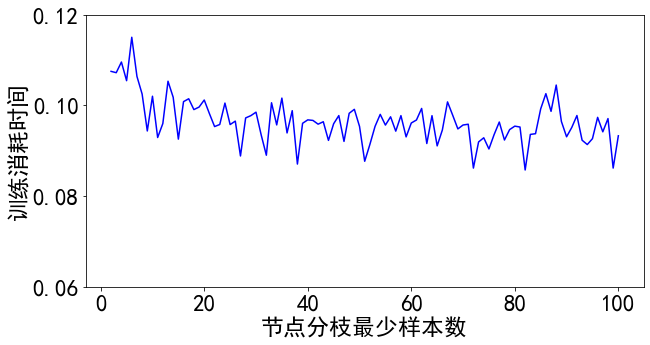

In [14]:
plt.figure(figsize=(10,5))
plt.ylim(0.06,0.12)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=23)
plt.ylabel('训练消耗时间', fontsize=23)
plt.xlabel('节点分枝最少样本数', fontsize=23)
plt.plot(range(2, 101),times,color="b")
plt.show()

In [15]:
# export_graphviz(tree,out_file="./tree/tree.dot",impurity=False,filled=True)
# with open("./tree/tree.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
# display(graph)

### 随机森林

In [16]:
# 模型参数设置
'''
第一类：
n_estimators：学习器的个数，interger，默认100
bootstrap：是否有放回抽样，boolean，默认True
第二类：
max_features：节点分裂时参与判断的最大特征数，默认auto，即sqrt(n_features)
max_depth：树的最大深度，int或None，默认None，表示对最大深度没有限制
min_samples_split：最小样本划分的数目，
min_samples_leaf：叶子节点最少样本数
'''

rfc = RandomForestClassifier(n_estimators = 200, max_depth = 25, min_samples_leaf = 2, min_samples_split = 3)
# rfc = RandomForestClassifier()
# 模型准确率和损失值
sum = 0
acc_list = []
loss_list = []
train_acc_list = []
print("开始训练")
for i in range(1,epoch +1):

    # 模型训练
    rfc.fit(m_train,train_label)
    
    # 测试集
    y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')

    # 计算准确率
    acc = round(accuracy_score(val_label, y_pred),3)
    
    # 训练集
    y_pred = np.asarray(rfc.predict(m_train),dtype = 'int64')
    # 计算准确率
    train_acc = round(accuracy_score(train_label, y_pred),3)
    
    # print('测试集准确率:', round(accuracy_score(val_label, y_pred),3))
    acc_list.append(acc)
    train_acc_list.append(train_acc)
    
    # 计算损失值
    # 使用one-hot编码计算损失值
    noe_hot = OneHotEncoder(sparse = False)

    y_pred_o = noe_hot.fit_transform(y_pred.reshape(1, -1))
    val_label_o = noe_hot.fit_transform(val_label.reshape(1, -1))
    
    print("完成第",i,"轮训练，测试集准确率：",acc)
    sum += acc
print("平均准确率：", sum / i)

开始训练
完成第 1 轮训练，测试集准确率： 0.975
完成第 2 轮训练，测试集准确率： 0.971
完成第 3 轮训练，测试集准确率： 0.975
完成第 4 轮训练，测试集准确率： 0.969
完成第 5 轮训练，测试集准确率： 0.971
完成第 6 轮训练，测试集准确率： 0.974
完成第 7 轮训练，测试集准确率： 0.972
完成第 8 轮训练，测试集准确率： 0.972
完成第 9 轮训练，测试集准确率： 0.976
完成第 10 轮训练，测试集准确率： 0.972
平均准确率： 0.9726999999999999


20


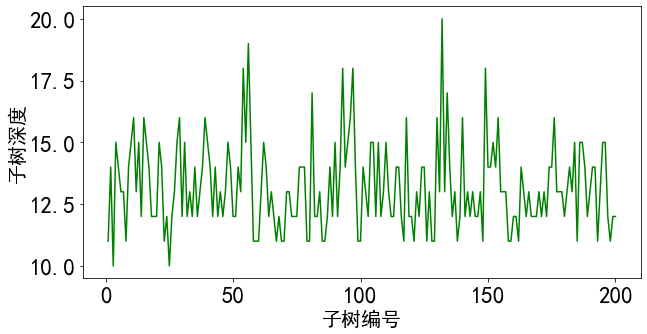

In [17]:
depth = []
for tree in rfc.estimators_:
    depth.append(tree.get_depth())
print(max(depth))
plt.figure(figsize=(10,5))
plt.xlabel('子树编号',fontsize = 20)
plt.ylabel('子树深度', fontsize = 20)
plt.tick_params(labelsize=23)
plt.plot(range(1, len(depth) + 1),depth,color="g")
plt.show()

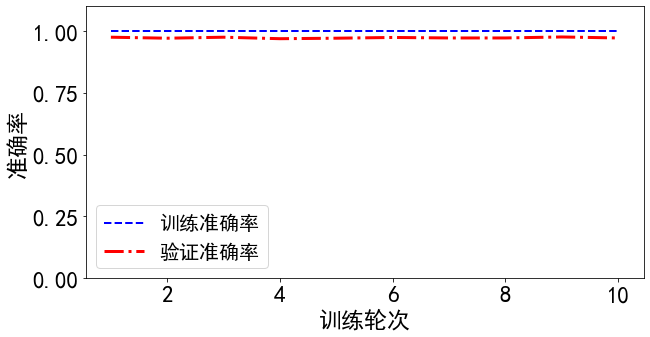

In [18]:
# 设置Y轴范围
plt.figure(figsize=(10,5))
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('训练轮次', fontsize=23)
plt.ylim(0,1.1)
# 训练准确率曲线
show_data1 = train_acc_list
# 测试准确率曲线
show_data2 = acc_list
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['训练准确率','验证准确率'],fontsize=20)
plt.show()

In [19]:
y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),3))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.972
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       156
           1       0.95      0.98      0.96       135
           2       1.00      1.00      1.00       144
           3       0.96      0.97      0.97       144
           4       0.98      0.95      0.96       141

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720



In [20]:
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz
# tree = rfc.estimators_[10]
# export_graphviz(tree,out_file="./tree/tree_of_forest.dot")
# with open("./tree/tree_of_forest.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
    
# display(graph)

Confusion matrix, without normalization
[[150   0   0   6   0]
 [  0 132   0   0   3]
 [  0   0 144   0   0]
 [  4   0   0 140   0]
 [  0   7   0   0 134]]


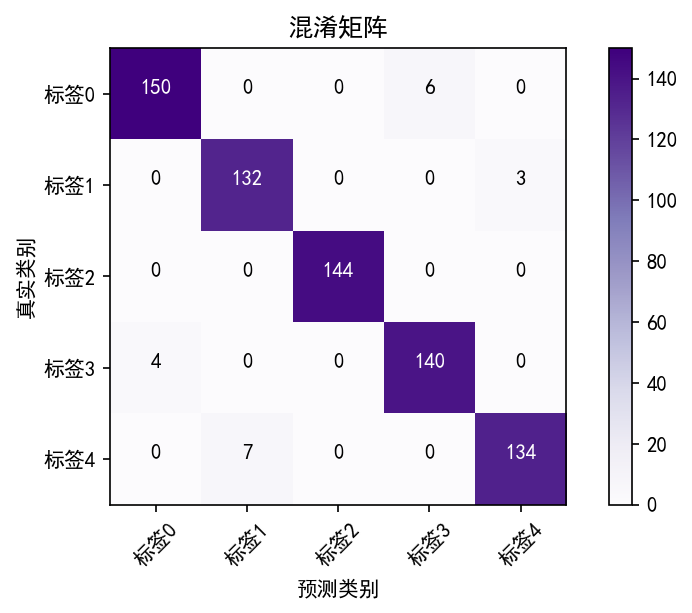

In [21]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")

In [23]:
# 决策树剪枝
import time
times = []
test = []
for i in range(2, 51):
    sum = 0
    start_time = time.time()
    for j in range(1, epoch +1):
        rfc = RandomForestClassifier(n_estimators = 70, max_depth = 21, min_samples_leaf = 2, min_samples_split = i)
        rfc.fit(m_train,train_label)
        y_pred = np.asarray(rfc.predict(m_val),dtype = 'int64')
        sum += round(accuracy_score(val_label, y_pred),3) 
    print("第", i, "轮")
    end_time = time.time()
    times.append((end_time - start_time) / epoch)
    score = sum / epoch
    test.append(score)

第 2 轮
第 3 轮
第 4 轮
第 5 轮
第 6 轮
第 7 轮
第 8 轮
第 9 轮
第 10 轮
第 11 轮
第 12 轮
第 13 轮
第 14 轮
第 15 轮
第 16 轮
第 17 轮
第 18 轮
第 19 轮
第 20 轮
第 21 轮
第 22 轮
第 23 轮
第 24 轮
第 25 轮
第 26 轮
第 27 轮
第 28 轮
第 29 轮
第 30 轮
第 31 轮
第 32 轮
第 33 轮
第 34 轮
第 35 轮
第 36 轮
第 37 轮
第 38 轮
第 39 轮
第 40 轮
第 41 轮
第 42 轮
第 43 轮
第 44 轮
第 45 轮
第 46 轮
第 47 轮
第 48 轮
第 49 轮
第 50 轮


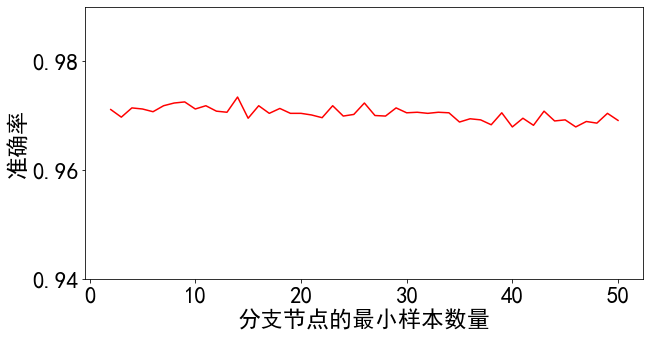

In [24]:
plt.figure(figsize=(10,5))
plt.ylim(0.94,0.99)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('分支节点的最小样本数量', fontsize=23)
plt.plot(range(2, 51),test,color="red")
plt.show()

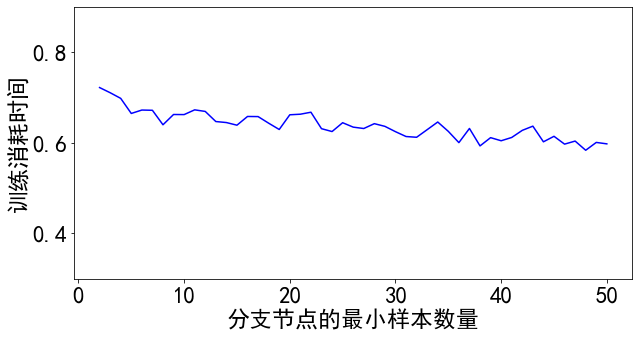

In [25]:
plt.figure(figsize=(10,5))
plt.ylim(0.3,0.9)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tick_params(labelsize=23)
plt.ylabel('训练消耗时间', fontsize=23)
plt.xlabel('分支节点的最小样本数量', fontsize=23)
plt.plot(range(2, 51),times,color="b")
plt.show()

# CNN

In [30]:
from tensorflow import keras
from tensorflow.keras import layers, models
import time
Dense = layers.Dense
Dropout = layers.Dropout
Activation = layers.Activation
Conv1D = layers.Conv1D
MaxPooling1D = layers.MaxPooling1D
Flatten = layers.Flatten
# 查看GPU是否可用
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [31]:
def cnn_create():
    num_filters = 3
    filter_size = 1
    pool_size = 1

    model = models.Sequential([
      Conv1D(num_filters, filter_size, input_shape=(36, 3)),
      MaxPooling1D(pool_size=pool_size),
      Flatten(),
      Dense(8, activation='relu'),
      Dense(label_count, activation='softmax'),
    ])
    
    model.compile('adam',  loss='sparse_categorical_crossentropy',  metrics=['accuracy'],)
    print("实例化模型成功，参数如下：")
    print(model.summary())
    return model

In [32]:
# 实例化模型
cnn_model = cnn_create()

# 设置模型log输出地址
log_dir = os.path.join("logs/CNN")
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

实例化模型成功，参数如下：
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 36, 3)             12        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 3)             0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 872       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
# 模型训练
start = time.clock()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = cnn_model.fit(train_data, train_label,epochs=20, batch_size=32, validation_split=0.2,callbacks=[tensorboard_callback])

Train on 1344 samples, validate on 336 samples
Epoch 1/20
1344/1344 [==============================] - 5s 4ms/sample - loss: 2.4394 - accuracy: 0.2537 - val_loss: 1.5324 - val_accuracy: 0.3512
Epoch 2/20
1344/1344 [==============================] - 0s 227us/sample - loss: 1.5434 - accuracy: 0.3371 - val_loss: 1.5079 - val_accuracy: 0.3899
Epoch 3/20
1344/1344 [==============================] - 0s 216us/sample - loss: 1.5193 - accuracy: 0.3735 - val_loss: 1.4875 - val_accuracy: 0.3869
Epoch 4/20
1344/1344 [==============================] - 0s 242us/sample - loss: 1.4982 - accuracy: 0.3728 - val_loss: 1.4710 - val_accuracy: 0.3839
Epoch 5/20
1344/1344 [==============================] - 0s 222us/sample - loss: 1.4767 - accuracy: 0.3869 - val_loss: 1.4470 - val_accuracy: 0.3958
Epoch 6/20
1344/1344 [==============================] - 0s 236us/sample - loss: 1.4510 - accuracy: 0.3906 - val_loss: 1.4277 - val_accuracy: 0.3899
Epoch 7/20
1344/1344 [==============================] - 0s 188us/sa

In [34]:
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,accuracy_score,log_loss
print("*****完成预处理，进行模型评估*****")
y_pred = cnn_model.predict(val_data)
y_pred = [np.argmax(x) for x in y_pred]

*****完成预处理，进行模型评估*****


In [35]:
print('------------------测试集上得分：------------------------')
print('*' * 5)
print('测试集准确率得分:', round(accuracy_score(val_label, y_pred),6))
print('*' * 5)
print('准确率、召回率、f1-值测试报告如下:\n', classification_report(val_label, y_pred))

------------------测试集上得分：------------------------
*****
测试集准确率得分: 0.419444
*****
准确率、召回率、f1-值测试报告如下:
               precision    recall  f1-score   support

           0       0.36      0.47      0.41       156
           1       0.46      0.13      0.21       135
           2       0.57      0.12      0.20       144
           3       0.44      0.44      0.44       144
           4       0.43      0.91      0.59       141

    accuracy                           0.42       720
   macro avg       0.45      0.42      0.37       720
weighted avg       0.45      0.42      0.37       720



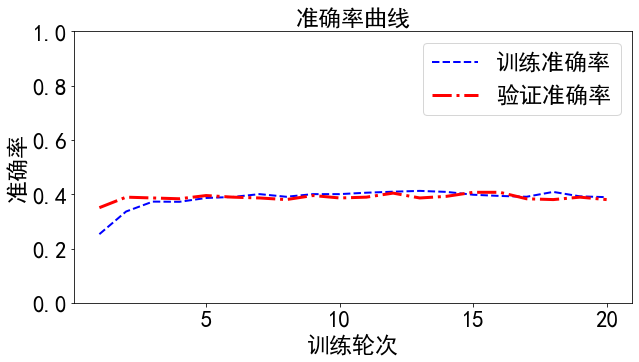

In [36]:
# 设置Y轴范围
plt.figure(figsize=(10,5))
plt.title("准确率曲线", fontsize=23)
plt.tick_params(labelsize=23)
plt.ylabel('准确率', fontsize=23)
plt.xlabel('训练轮次', fontsize=23)
plt.ylim(0,1)
# 训练准确率曲线
show_data1 = history.history['accuracy']
# 测试准确率曲线
show_data2 = history.history['val_accuracy']
x_data = list(range(1,len(show_data1)+1))
ln1, = plt.plot(x_data,show_data1,color='blue',linewidth=2.0,linestyle='--')
ln2, = plt.plot(x_data,show_data2,color='red',linewidth=3.0,linestyle='-.')
plt.legend(handles=[ln1,ln2],labels=['训练准确率','验证准确率'], fontsize=23)
plt.show()

Confusion matrix, without normalization
[[ 74   0   1  81   0]
 [  7  18   8   0 102]
 [ 45  14  17   0  68]
 [ 79   0   1  64   0]
 [  2   7   3   0 129]]


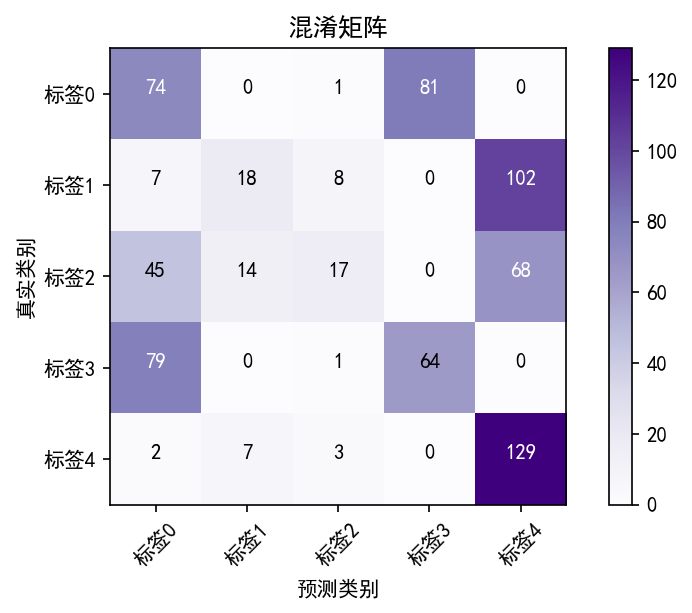

In [37]:
cmt_sklearn = confusion_matrix(val_label, y_pred)
plot_confusion_matrix(cmt_sklearn, ["标签0", "标签1", "标签2", "标签3", "标签4"], title = "混淆矩阵")